In [2]:
NAME = "Piotr Szuba"

WSTĘP - WYNIKI !!!!


In [3]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy")

In [310]:
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from typing import List, Tuple, Type
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import (
    BaggingClassifier,
    AdaBoostClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
)
from sklearn.model_selection import (
    RepeatedStratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_validate,
    RepeatedKFold,
)

random_state = 1

<h1> UTILS</h1>

In [311]:
class Classifier:
    def __init__(self):
        pass

    def fit(self, X, y):
        pass

    def predict(self, X):
        pass


class DataClass:
    target_feature: str = ""

    def get_dataFrame() -> pd.DataFrame:
        raise NotImplementedError()


def convert_cell(series: pd.Series):
    converted = pd.to_numeric(series, errors="coerce", downcast="float")
    converted = converted.replace([np.inf, -np.inf], np.nan)
    converted = converted.fillna(np.nan)
    return converted


def clear_data(data: pd.DataFrame, target_feature: str):
    classes = data[target_feature]
    columns = data.columns.drop(target_feature)

    df = data[columns].apply(lambda x: convert_cell(x))

    imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=columns)

    return pd.concat([imputed_df, classes], axis=1)


def remove_outliers_lof(data: pd.DataFrame, target_feature: str) -> pd.DataFrame:
    X = data.drop(columns=[target_feature])
    y = data[target_feature]

    lof = LocalOutlierFactor()
    outlier_labels = lof.fit_predict(X)

    inlier_mask = outlier_labels == 1
    X_clean = X.loc[inlier_mask]
    y_clean = y.loc[inlier_mask]

    return pd.concat([X_clean, y_clean], axis=1)


def split_train_test(
    data: pd.DataFrame, target_feature: str, test_size: float = 0.3
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_data, test_data = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state,
        stratify=data[target_feature],
    )

    return train_data, test_data


def split_features(
    train_data: pd.DataFrame, test_data: pd.DataFrame, target_feature: str
):
    X_train = train_data[[col for col in train_data.columns if col != target_feature]]
    y_train = train_data[target_feature]
    X_test = test_data[[col for col in test_data.columns if col != target_feature]]
    y_test = test_data[target_feature]

    return X_train, y_train, X_test, y_test


def scale_numeric_features(
    X_train: np.ndarray, X_test: np.ndarray
) -> Tuple[np.ndarray, np.ndarray]:
    scaler = StandardScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled


def apply_pca(
    X_train: np.ndarray, X_test: np.ndarray, components: int = 2
) -> Tuple[np.ndarray, np.ndarray]:
    n_features = X_train.shape[1]
    n_components = min(components, n_features)
    pca = PCA(n_components=n_components)

    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    return X_train_pca, X_test_pca


def train_model(clf: Classifier, data_class: Type[DataClass],):
    target_feature = data_class.target_feature

    data = data_class.get_dataFrame()
    clean_data = clear_data(data, target_feature)

    clean_data = remove_outliers_lof(clean_data, target_feature)

    train_data, test_data = split_train_test(clean_data, target_feature)

    X_train, y_train, X_test, y_test = split_features(
        train_data, test_data, target_feature
    )

    X_train, X_test = scale_numeric_features(X_train, X_test)

    clf.fit(X_train, y_train.squeeze())

    return clf, X_test, y_test

<h3>Dataloaders</h3>

In [35]:
class Iris(DataClass):
    sepal_length = "sepal-length"
    sepal_width = "sepal-width"
    petal_length = "petal-length"
    petal_width = "petal-width"
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "iris.data",
            names=[
                Iris.sepal_length,
                Iris.sepal_width,
                Iris.petal_length,
                Iris.petal_width,
                Iris.target_feature,
            ],
        )

        return data


class Wine:
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "wine.data",
            names=[
                Wine.target_feature,
                "Alcohol",
                "Malic acid",
                "Ash",
                "Alcanity of ash",
                "Magnesium",
                "Total phenols",
                "Flavanoids",
                "Nonflavanoid phenosis",
                "Proanthocyanins",
                "Color intensity",
                "Hue",
                "OD280/OD315 of diluted wine",
                "Proline",
            ],
        )

        return data


class Seeds(DataClass):
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "seeds.data",
            names=[
                "area A",
                "perimeter P",
                "compactness C = 4*pi*A/P^2",
                "length of kernel",
                "width of kernel",
                "asymmetry coefficient",
                "length of kernel groove",
                Seeds.target_feature,
            ],
        )

        return data


class Glass(DataClass):
    target_feature = "Type of glass"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "glass.data",
            names=[
                "Id number: 1 to 214",
                "RI: refractive index",
                "Na: Sodium",
                "Mg: Magnesium",
                "Al: Aluminum",
                "Si: Silicon",
                "K: Potassium",
                "Ca: Calcium",
                "Ba: Barium",
                "Fe: Iron",
                Glass.target_feature,
            ],
        )

        return data

In [37]:
def plot_confusion_matrix(clf: Classifier, X_test: np.ndarray, y_test: np.ndarray):
    y_pred = clf.predict(X_test)
    print(classification_report(y_test, y_pred, zero_division=0))
    ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test.squeeze())
    plt.show()


def classification_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f_score = f1_score(y_true, y_pred, average="weighted")

    return cm, accuracy, precision, recall, f_score


def print_stats(accuracy: float, precision: float, recall: float, f_score: float):
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f_score:.4f}")


def get_and_print_stats(clf: Classifier, X_test: np.ndarray, y_test: np.ndarray):
    y_pred = clf.predict(X_test)
    cm, accuracy, precision, recall, f_score = classification_metrics(y_test, y_pred)

    print_stats(accuracy, precision, recall, f_score)

<h2>Testing</h2>

In [312]:
class ClassifierTester:
    def __init__(self) -> None:
        self.permutations = []
    
    def create_model(self, permutation_number: int) -> Classifier:
        raise NotImplementedError()

    def get_permutations_count(self) -> int:
        return len(self.permutations)
    
    def update_results(self, result: dict, permutation_number: int) -> dict:
        raise NotImplementedError()
    
    def validate_params(self, data_class: DataClass, permutation_number: int):
        return True
    
    def _validate_input(self, permutation_number: int):
        if permutation_number < 0 or permutation_number >= self.get_permutations_count():
            raise ValueError("Invalid permutation_number")
        
    def get_param_names() -> list[str]:
        raise NotImplementedError()

class BaggingTester(ClassifierTester):
    
    def __init__(self) -> None:
        super().__init__()
        self._bootstraps = [True, False]
        self._num_classifiers = [5, 10, 15, 20, 25]
        self._num_samples = [1, 3, 5, 10, 15, 20, 25]
        self._num_features = [1, 2, 5, 7, 10, 13]
        self.permutations = list(
            itertools.product(
                self._bootstraps,
                self._num_classifiers,
                self._num_samples,
                self._num_features,
            )
        )

    def create_model(self, permutation_number: int) -> BaggingClassifier:
        super()._validate_input(permutation_number)
        
        parameters = self.permutations[permutation_number]
        bootstrap, num_classifiers, num_samples, num_features = parameters
        
        return BaggingClassifier(
            estimator=DecisionTreeClassifier(max_depth=2),
            n_estimators=num_classifiers,
            max_samples=num_samples,
            max_features=num_features,
            bootstrap=bootstrap,
            random_state=random_state,
        )
    
    def update_results(self, result: dict, permutation_number: int) -> dict:
        parameters = self.permutations[permutation_number]
        bootstrap, num_classifiers, num_samples, num_features = parameters
        result.update({
            'bootstrap': bootstrap,
            'num_classifiers': num_classifiers,
            'num_samples': num_samples,
            'num_features': num_features
        })
        return result
    
    def validate_params(self, data_class: DataClass, permutation_number: int):
        data = data_class.get_dataFrame()
        _, num_total_columns = data.shape
        num_features = num_total_columns - 1 
        _, _, _, max_features = self.permutations[permutation_number]

        return max_features <= num_features
    
    def get_param_names():
        return ['bootstrap', 'num_classifiers', 'num_samples', 'num_features']


class AdaBoostTester(ClassifierTester):
    def __init__(self) -> None:
        super().__init__()
        self._num_classifiers = [5, 10, 25, 50, 100]
        self._learning_rates = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]
        self.permutations = list(
            itertools.product(
                self._num_classifiers,
                self._learning_rates,
            )
        )

    def create_model(self, permutation_number: int) -> AdaBoostClassifier:
        super()._validate_input(permutation_number)
        
        parameters = self.permutations[permutation_number]
        num_classifiers, learning_rate = parameters
        
        return AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=2),
            n_estimators=num_classifiers,
            learning_rate=learning_rate,
            random_state=random_state,
        )
        
    def update_results(self, result: dict, permutation_number: int) -> dict:
        parameters = self.permutations[permutation_number]
        num_classifiers, learning_rate = parameters
        result.update({
            'num_classifiers': num_classifiers,
            'learning_rate': learning_rate
        })
        return result
    
    def get_param_names():
        return ['num_classifiers', 'learning_rate']

class RandomForestTester(ClassifierTester):
    def __init__(self) -> None:
        super().__init__()
        self._num_samples = [25, 50, 100, 120, 140, 149]
        self._num_features = [1, 2, 5, 7, 10, 13]
        self._num_trees = [10, 50, 75, 100]
        self._max_depth = [5, 10, 15, 20]
        self.permutations = list(
            itertools.product(
                self._num_samples,
                self._num_features,
                self._num_trees,
                self._max_depth,
            )
        )

    def create_model(self, permutation_number: int) -> RandomForestClassifier:
        super()._validate_input(permutation_number)
        
        parameters = self.permutations[permutation_number]
        num_samples, num_features, num_trees, max_depth = parameters
        
        return RandomForestClassifier(
            n_estimators=num_trees,
            max_samples=num_samples,
            max_features=num_features,
            max_depth=max_depth,
            random_state=random_state,
        )

    def update_results(self, result: dict, permutation_number: int) -> dict:
        parameters = self.permutations[permutation_number]
        num_samples, num_features, num_trees, max_depth = parameters
        result.update({
            'num_samples': num_samples,
            'num_features': num_features,
            'num_trees': num_trees,
            'max_depth': max_depth
        })
        return result
    
    def validate_params(self, data_class: Type[DataClass], permutation_number: int):
        target_feature= data_class.target_feature
        data = data_class.get_dataFrame()
        
        clean_data = remove_outliers_lof(data, target_feature)
        train_data, _ = split_train_test(clean_data, target_feature)
        num_samples, num_total_columns = train_data.shape
        num_features = num_total_columns - 1
        max_samples, max_features, _, _ = self.permutations[permutation_number]

        return max_features <= num_features and max_samples <= num_samples
    
    def get_param_names():
        return ['num_samples', 'num_features', 'num_trees', 'max_depth']
    
def test_classifier(tester_class: ClassifierTester) -> pd.DataFrame:
    datasets = [Glass, Wine, Seeds]
    results = []
    for i in tqdm(range(tester_class.get_permutations_count()), total=tester_class.get_permutations_count()):
        clf = tester_class.create_model(i)
        for dataset_class in datasets:
            if not tester_class.validate_params(dataset_class, i):
                continue
            clf, X_test, y_test = train_model(clf, dataset_class)
            y_pred = clf.predict(X_test)
            _, accuracy, precision, recall, f_score = classification_metrics(y_test, y_pred)  
            result_dict = {
                'dataset': dataset_class.__name__,
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f_score': f_score
            }
            
            result_dict = tester_class.update_results(result_dict, i)
            results.append(result_dict)
        
    df = pd.DataFrame(results)
    return df

In [364]:
def get_average_for_param(result: pd.DataFrame, param: str) -> pd.DataFrame:
    avg_scores = result.groupby([param, "dataset"])["f_score"].mean()
    avg_scores_df = avg_scores.reset_index()
    return avg_scores_df

def get_average_for_param_all_datasets(result: pd.DataFrame, param: str) -> pd.DataFrame:
    avg_scores = result.groupby([param])["f_score"].mean()
    avg_scores_df = avg_scores.reset_index()
    return avg_scores_df

def plot_avg_scores(result: pd.DataFrame, param: str):
    avg_scores = get_average_for_param(result, param)
    avg_scores_all = get_average_for_param_all_datasets(result, param)
    
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    
    sns.lineplot(data=avg_scores, x=param, y='f_score', hue='dataset', ax=axs[0])
    axs[0].set_xlabel(param.capitalize())
    axs[0].set_ylabel("Average Score")
    axs[0].set_title(f"Average Scores for Different {param.capitalize()} Values per Dataset")

    sns.lineplot(data=avg_scores_all, x=param, y='f_score', ax=axs[1])
    axs[1].set_xlabel(param.capitalize())
    axs[1].set_ylabel("Average Score")
    axs[1].set_title(f"Average Scores for Different {param.capitalize()} Values (All Datasets)")
    
    plt.show()

def plot_all_avg_scores(result: pd.DataFrame, params: list[str]):
    for param in params:
        plot_avg_scores(result, param)
        
def get_average_for_all_params(result_df: pd.DataFrame, params: List[str], dataclass: Type[DataClass] = None) -> pd.DataFrame:
    result = result_df.copy()
    
    if dataclass is not None:
        result = result.loc[result['dataset'] == dataclass.__name__]
        avg_scores_df = result.sort_values(by="f_score", ascending=False).head(1)
        cols_to_keep = params + ['f_score']
        avg_scores_df = avg_scores_df.loc[:, cols_to_keep]
        
        return avg_scores_df
        
    result["param_configuration"] = result[params].apply(tuple, axis=1)
    
    counts = result["param_configuration"].value_counts()
    valid_configurations = counts[counts > 2].index.tolist()
    result = result[result["param_configuration"].isin(valid_configurations)]
    
    avg_scores = result.groupby("param_configuration")["f_score"].mean()
    
    avg_scores_df = pd.DataFrame(avg_scores).reset_index()
    
    avg_scores_df[params] = pd.DataFrame(avg_scores_df["param_configuration"].tolist(), index=avg_scores_df.index)
    
    avg_scores_df = avg_scores_df.drop(columns=["param_configuration"])
    
    avg_scores_df = avg_scores_df.sort_values(by="f_score", ascending=False).head(1)
    
    return avg_scores_df.reset_index(drop=True)

                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.88      1.00      0.94        15
 Iris-virginica       1.00      0.86      0.92        14

       accuracy                           0.95        44
      macro avg       0.96      0.95      0.95        44
   weighted avg       0.96      0.95      0.95        44



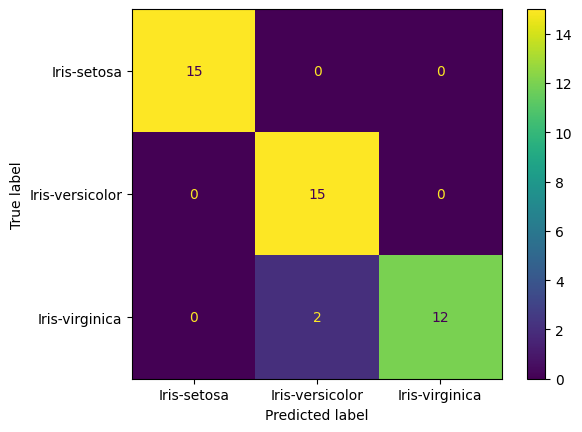

Accuracy: 0.9545
Precision: 0.9599
Recall: 0.9545
F1 Score: 0.9542


In [103]:
clf = DecisionTreeClassifier(max_depth=2)
clf, X_test, y_test = train_model(clf, Iris)
plot_confusion_matrix(clf, X_test, y_test)
get_and_print_stats(clf, X_test, y_test)

<h1>Bagging Test</h1>

In [253]:
bagging_results = test_classifier(BaggingTester())

  0%|          | 0/420 [00:00<?, ?it/s]

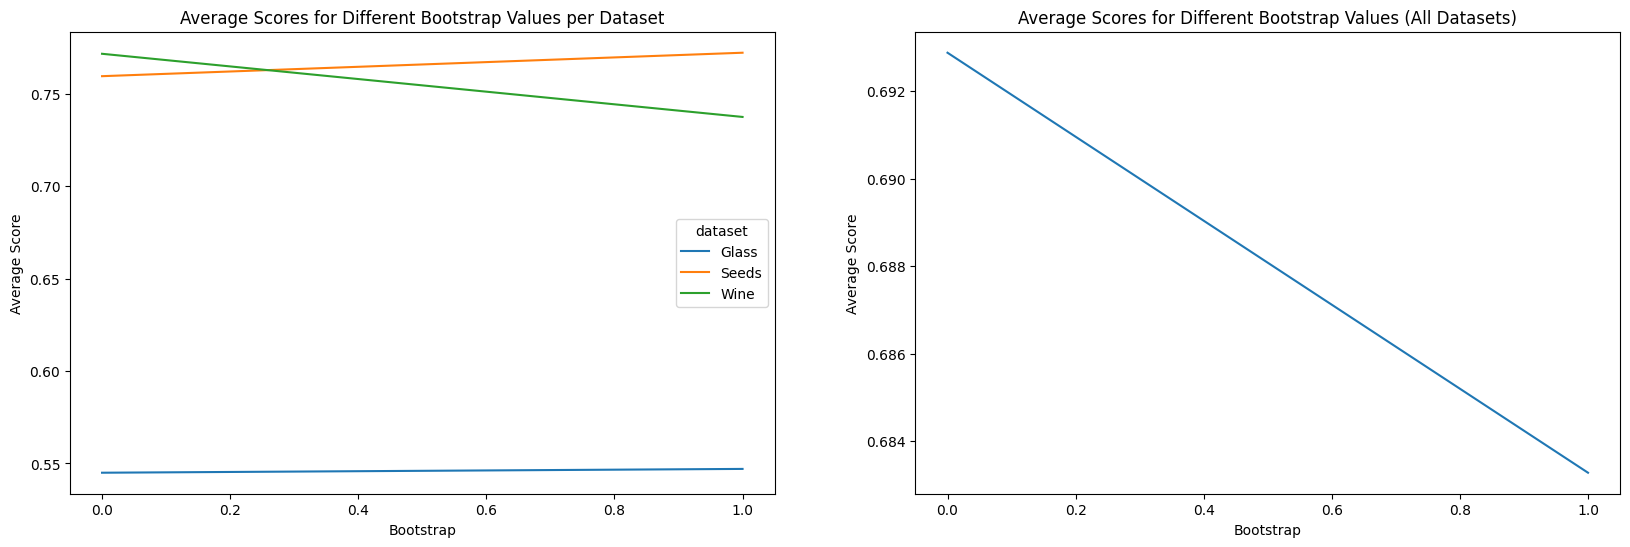

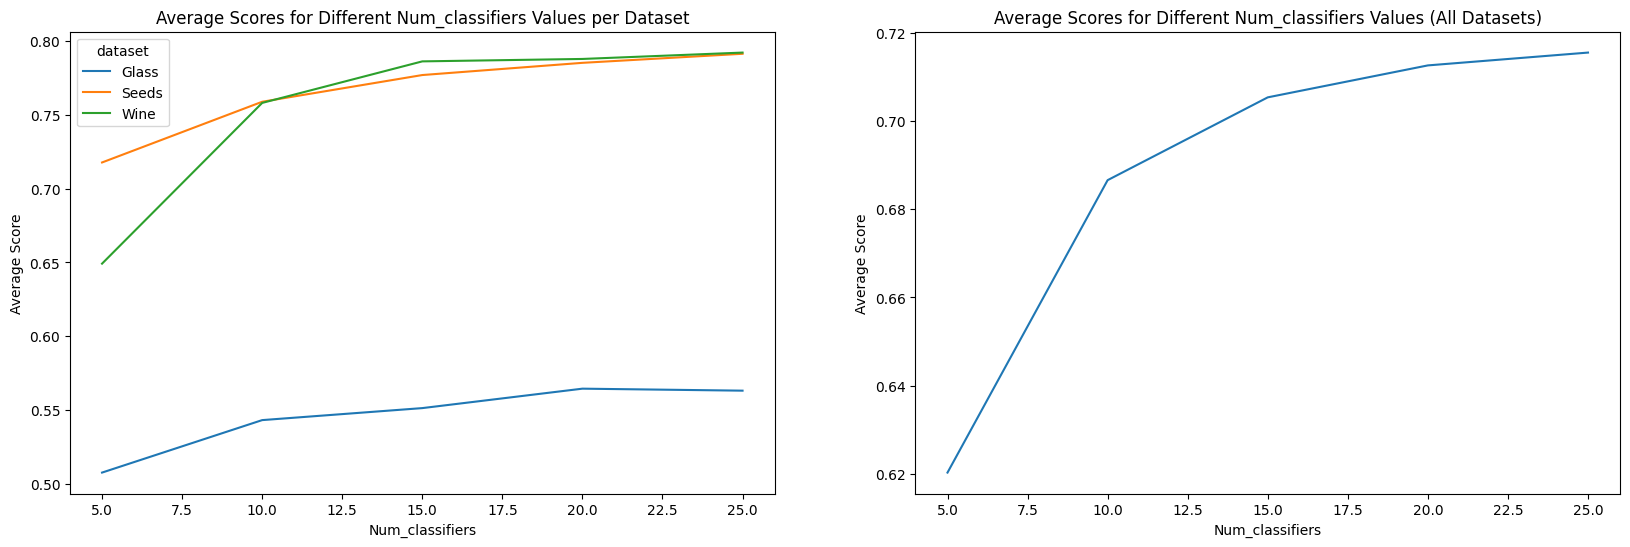

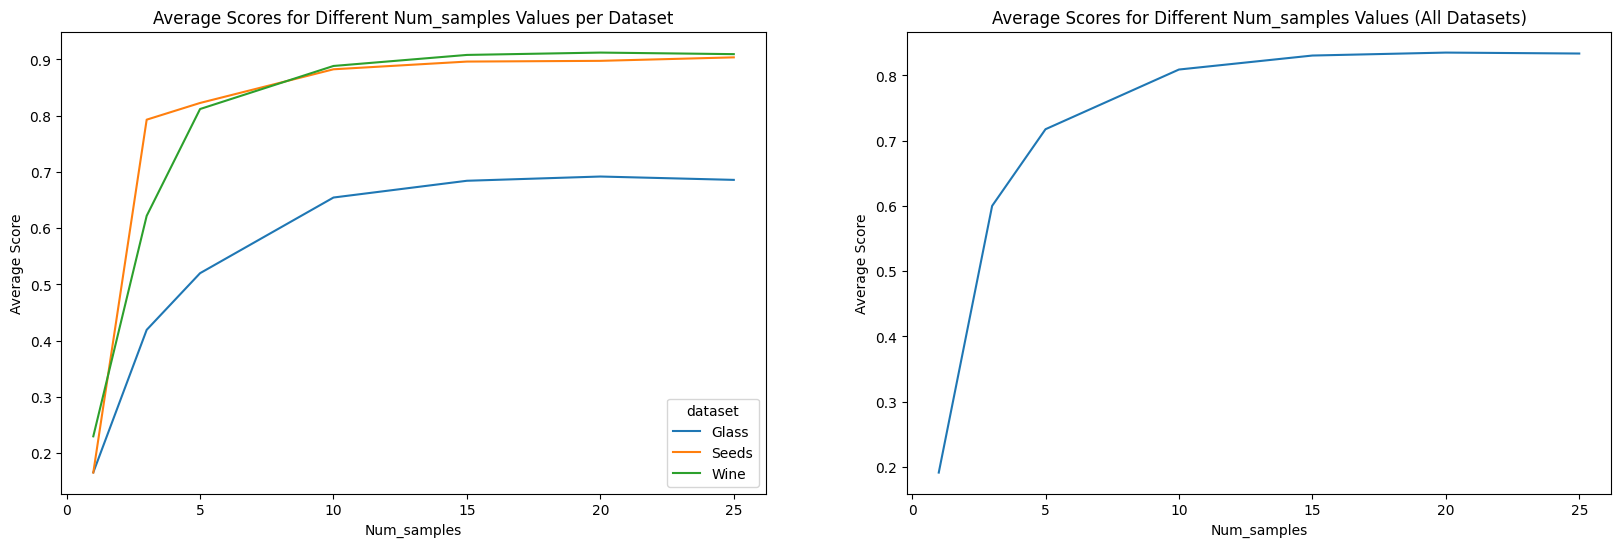

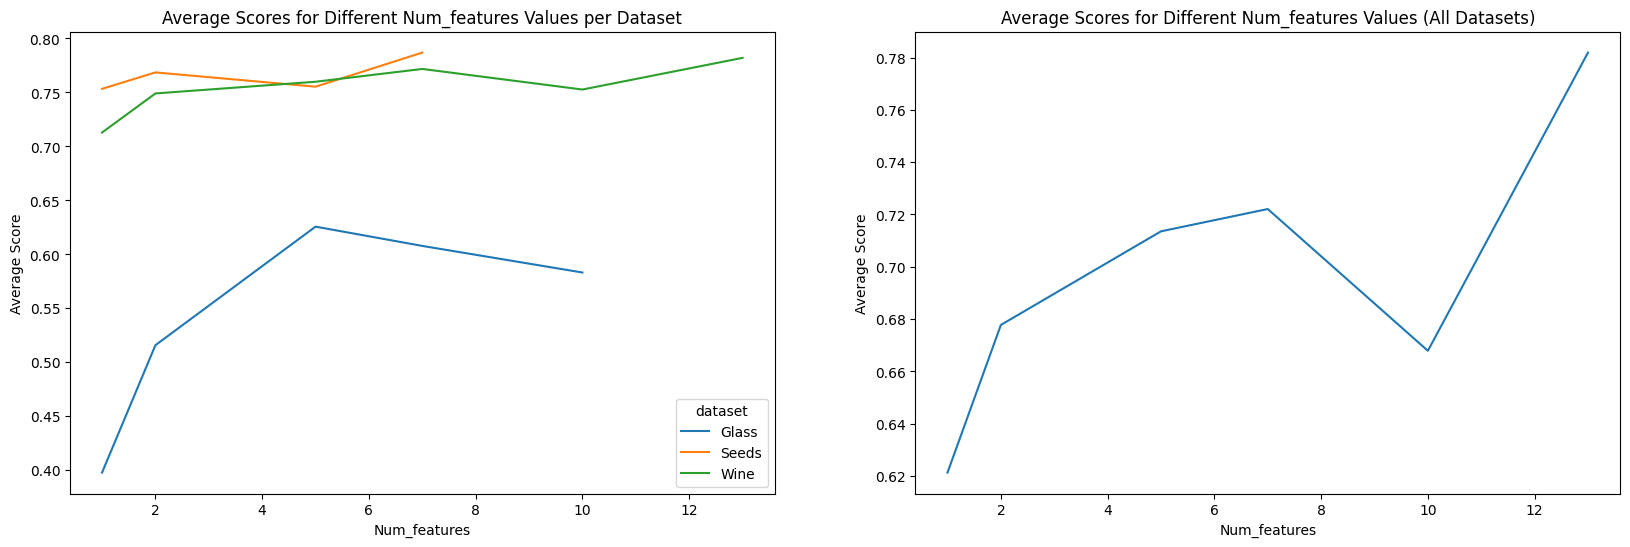

In [273]:
plot_all_avg_scores(bagging_results, BaggingTester.get_param_names())

<h1>AdaBoost Test</h1>

In [260]:
adaboost_results = test_classifier(AdaBoostTester())

  0%|          | 0/45 [00:00<?, ?it/s]

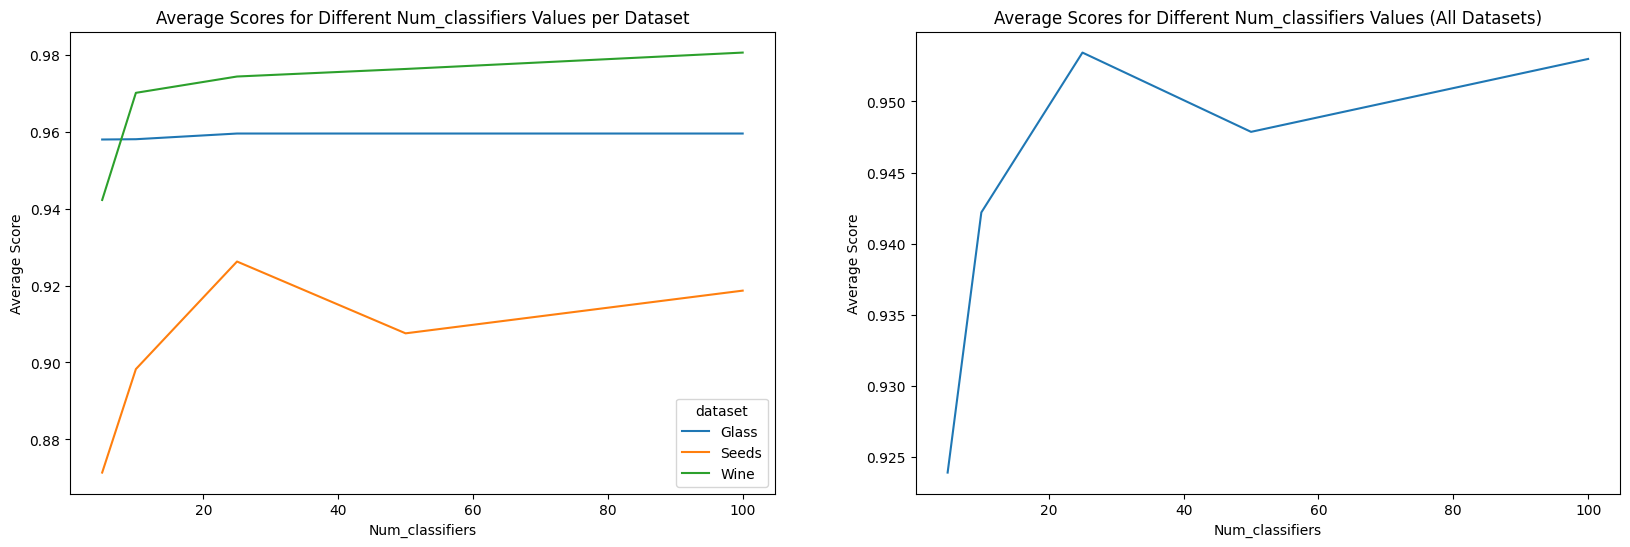

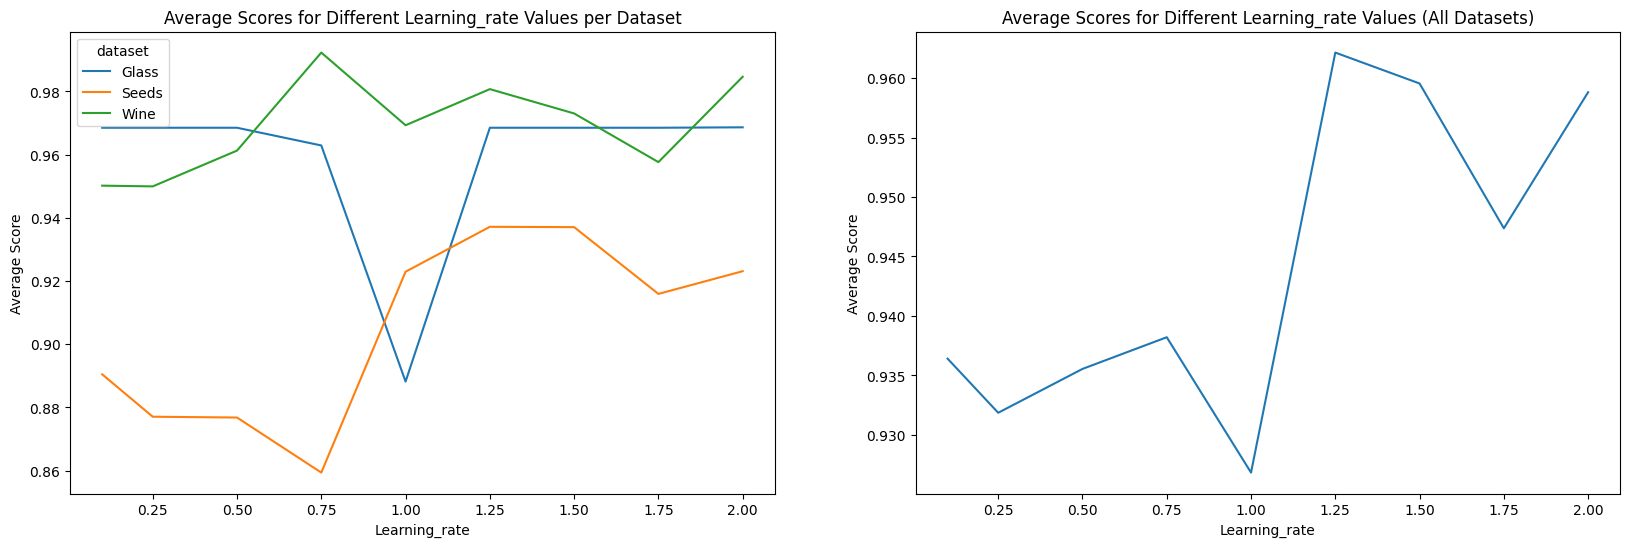

In [272]:
plot_all_avg_scores(adaboost_results, AdaBoostTester.get_param_names())

<h1>RandomForest Test</h1>

In [257]:
randomforest_results = test_classifier(RandomForestTester())

  0%|          | 0/576 [00:00<?, ?it/s]

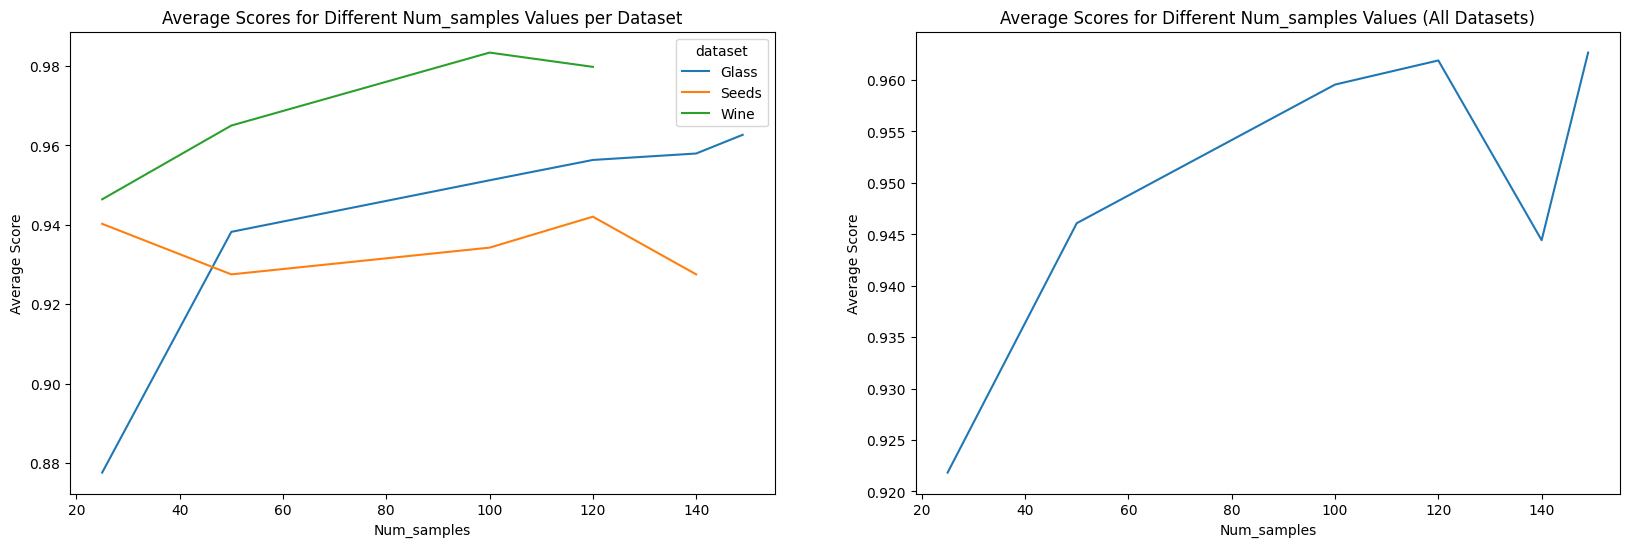

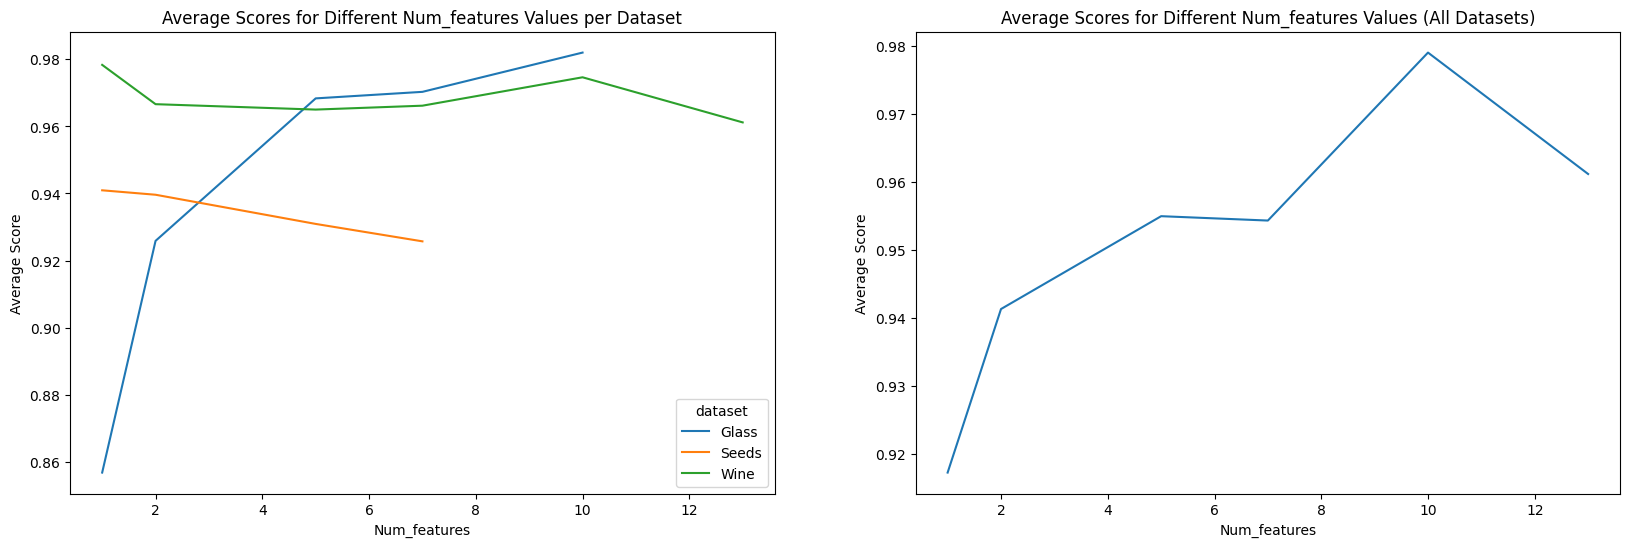

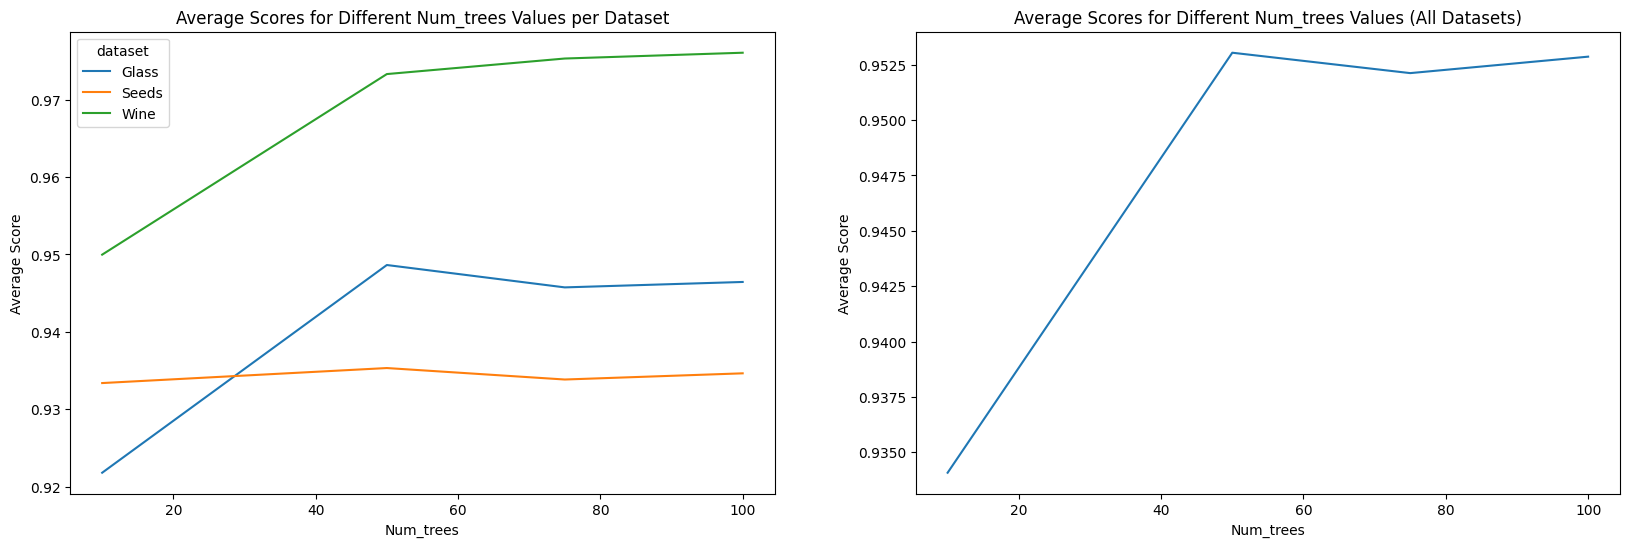

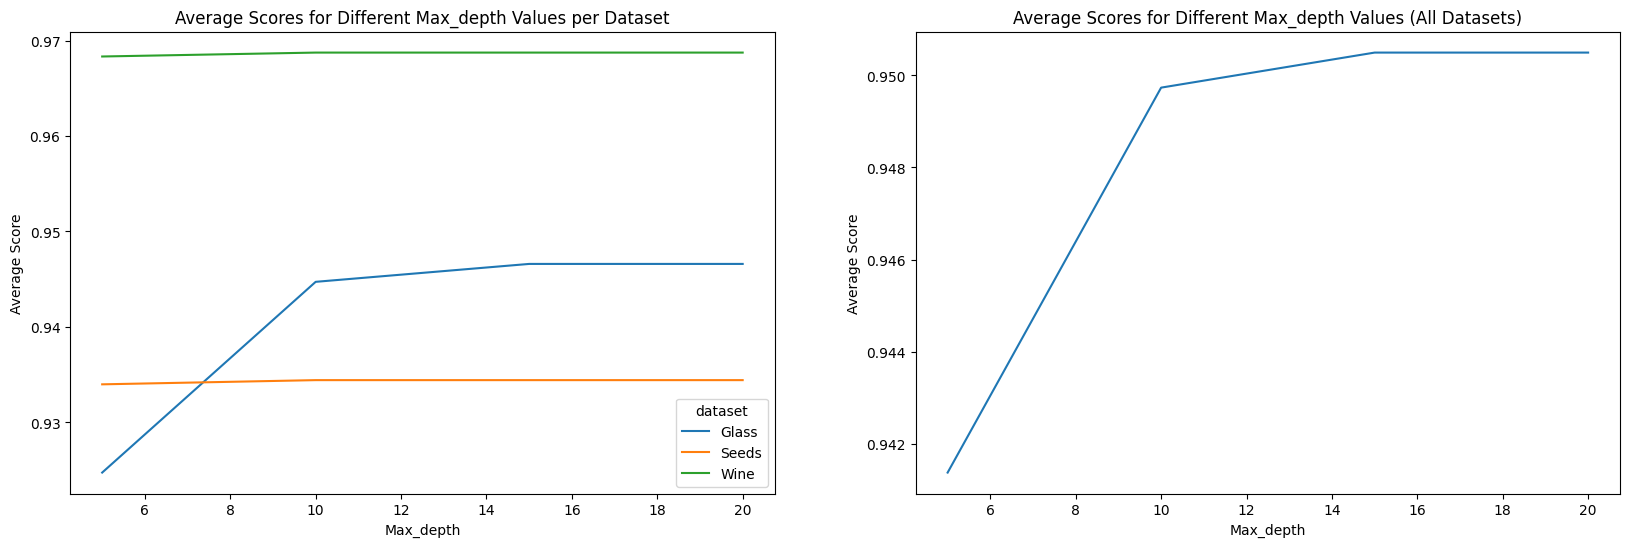

In [265]:
plot_all_avg_scores(randomforest_results, RandomForestTester.get_param_names())

<h1>Zestawienie najlepszych konfiguracji</h1>

In [361]:
def show_best_results(dataclass: Type[DataClass] = None):
    bagging_best = get_average_for_all_params(bagging_results, BaggingTester.get_param_names(), dataclass)
    adaboost_best = get_average_for_all_params(adaboost_results, AdaBoostTester.get_param_names(), dataclass)
    randomforest_best = get_average_for_all_params(randomforest_results, RandomForestTester.get_param_names(), dataclass)

    bagging_best['classifier'] = 'Bagging'
    adaboost_best['classifier'] = 'AdaBoost'
    randomforest_best['classifier'] = 'RandomForest'

    combined_top3 = pd.concat([bagging_best, adaboost_best, randomforest_best])
    combined_top3 = combined_top3.sort_values(by='f_score', ascending=False)

    plt.figure(figsize=(10,6))
    barplot = sns.barplot(data=combined_top3, x='classifier', y='f_score', palette='viridis')
    plt.title('Top Results for Each Classifier')
    plt.xlabel('Classifier')
    plt.ylabel('F_score')
    difference = (combined_top3['f_score'].max() - combined_top3['f_score'].min()) / 2
    plt.ylim(combined_top3['f_score'].min() - difference, 1.0)

    for p in barplot.patches:
        barplot.text(x = p.get_x() + p.get_width() / 2, 
                    y = p.get_height(),
                    s = "{:.6f}".format(p.get_height()), 
                    ha = 'center', color='black')

    plt.show()
    
    for classifier_df in [bagging_best, adaboost_best, randomforest_best]:
        classifier_name = classifier_df['classifier'].values[0]
        best_params = classifier_df.drop(columns=["f_score", "classifier"]).iloc[0].to_dict()
        print(f"Best parameters for {classifier_name}: {best_params}")

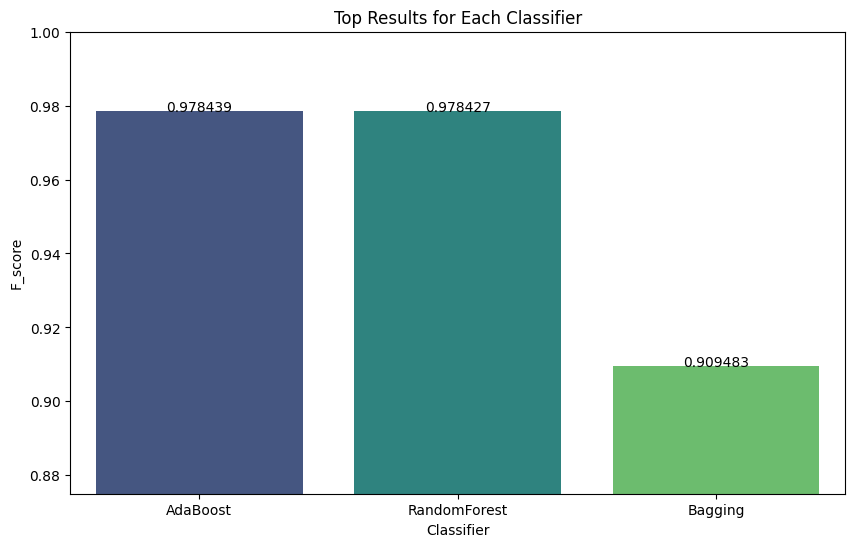

Best parameters for Bagging: {'bootstrap': False, 'num_classifiers': 25, 'num_samples': 20, 'num_features': 7}
Best parameters for AdaBoost: {'num_classifiers': 25.0, 'learning_rate': 2.0}
Best parameters for RandomForest: {'num_samples': 120, 'num_features': 2, 'num_trees': 100, 'max_depth': 15}


In [362]:
show_best_results()

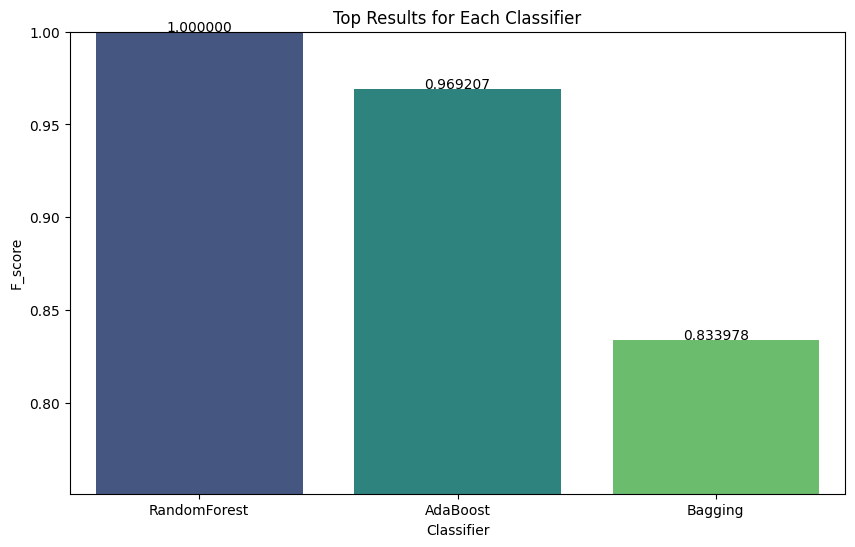

Best parameters for Bagging: {'bootstrap': True, 'num_classifiers': 10, 'num_samples': 20, 'num_features': 5}
Best parameters for AdaBoost: {'num_classifiers': 10.0, 'learning_rate': 2.0}
Best parameters for RandomForest: {'num_samples': 25, 'num_features': 10, 'num_trees': 10, 'max_depth': 20}


In [365]:
show_best_results(Glass)


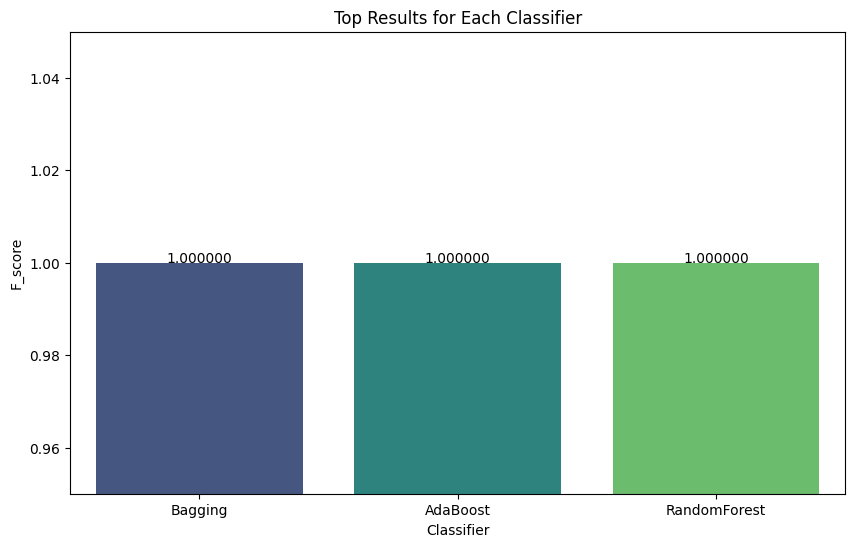

Best parameters for Bagging: {'bootstrap': False, 'num_classifiers': 20, 'num_samples': 10, 'num_features': 2}
Best parameters for AdaBoost: {'num_classifiers': 10.0, 'learning_rate': 0.75}
Best parameters for RandomForest: {'num_samples': 100, 'num_features': 10, 'num_trees': 10, 'max_depth': 10}


In [366]:
show_best_results(Wine)

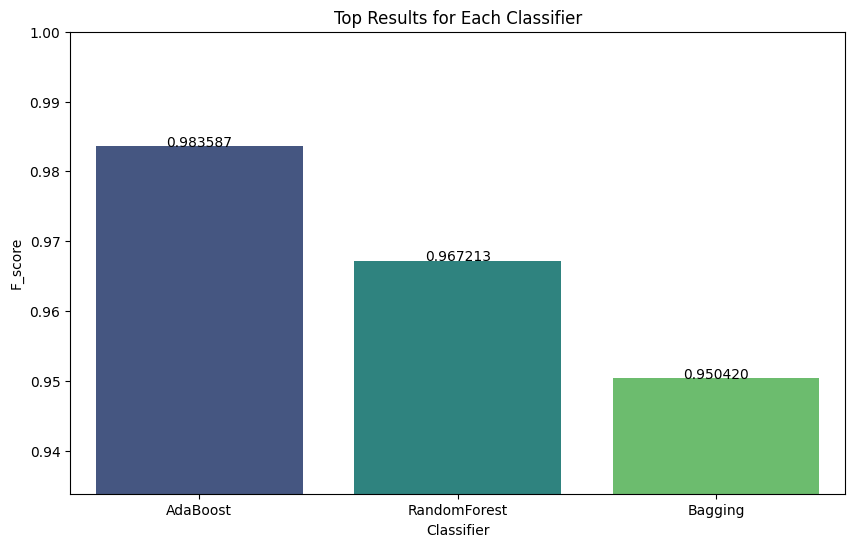

Best parameters for Bagging: {'bootstrap': True, 'num_classifiers': 20, 'num_samples': 20, 'num_features': 2}
Best parameters for AdaBoost: {'num_classifiers': 10.0, 'learning_rate': 1.0}
Best parameters for RandomForest: {'num_samples': 50, 'num_features': 1, 'num_trees': 10, 'max_depth': 10}


In [367]:
show_best_results(Seeds)

<h1>Zakończenie</h1>